###<center> Hierarchical Attention Networks for Document Classification Zichao Yang paper</center>
it has two levels of attention mechanisms applied at the word and  sentence level. Unlike other deep learning models it does not give equal importance to all the words in a document (more like calculating tf-idf values using neural network). In this paper they capture the importance of words first at sentence level and then at document level. The output from bi directionl GRU which captures contextual information is fed into a shallow neural network with tanh activation function which is then multiplied by trainable **context vector** and normalized to an importance weight per word by softmax function.
The sum of these importance weights concatenated with the previously calculated  GRU output is called sentence vector.The same procedure is repeated for sentence vector the resulting output is a document vector  which can be used as features for document classification. 
<center><img src= "https://www.researchgate.net/profile/Kamran_Kowsari/publication/332463886/figure/fig18/AS:748520504053760@1555472603010/Hierarchical-Attention-Networks-for-document-classification.png" alt= "HAN arch" width="400" /></center>
Inside attention network
<center><img src= "https://humboldt-wi.github.io/blog/img/seminar/group5_HAN/han_word.png" width="500" /></center>

Some of their hyperparameter:
embedding dimension : 100
bi-GRU(hidden units): 50 
Optimizer : SGD with momentum 0.9 and lr was found using grid search
mini batch : 64 (documents of similar length were organized to be a batch)


In [0]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN%23")
test_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST%23")

In [1]:
import os
import time
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

from keras.layers import Dense, Input, Embedding, Dropout, Activation, GRU, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import initializers, regularizers, constraints, optimizers, layers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import *
from keras.models import *
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *





Using TensorFlow backend.


In [0]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## split to train and val
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2048,stratify=train_df["class"])

## some config values 
embed_size = 100 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use

## fill up the missing values
train_X = train_df["tweet"].fillna("_na_").values
val_X = val_df["tweet"].fillna("_na_").values
test_X = test_df["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features,filters="")
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen,padding='post',truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen,padding='post',truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen,padding='post',truncating='post')

## Get the target values
train_y = train_df['class'].values
val_y = val_df['class'].values


In [0]:
def load_glove_index():
    EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [0]:
glove_embedding_index.get('hi').shape

(100,)

In [0]:
num_words = max_features

embedding_matrix = np.zeros((num_words, embed_size))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embedding_index.get(word)

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
      embedding_matrix[i] = embedding_vector
    else:
        if word.islower():
                # try to get the embedding of word in titlecase if lowercase is not present
                embedding_vector = glove_embedding_index.get(word.capitalize())
                if embedding_vector is not None: 
                    embedding_matrix[i] = embedding_vector

In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='kernel',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='bias',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
      return input_shape[0],  self.features_dim


In [0]:
def evaluate(y, pred):
    f1_list = list()
    thre_list = np.arange(0.1, 0.501, 0.01)
    for thresh in thre_list:
        thresh = np.round(thresh, 2)
        f1 = metrics.f1_score(y, (pred>thresh).astype(int))
        f1_list.append(f1)
        print("F1 score at threshold {0} is {1}".format(thresh, f1))
    #return f1_list
    #plot_confusion_matrix(y, np.array(pd.Series(pred.reshape(-1,)).map(lambda x:1 if x>thre_list[np.argmax(f1_list)] else 0)))
    print('Best Threshold: ',thre_list[np.argmax(f1_list)])
    return thre_list[np.argmax(f1_list)]

In [0]:
def attention(embedding_matrix=embedding_matrix, num_att=5, gru_units=64):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

    
    def attention_block(layer, atten_len=maxlen, num_multi=num_att, dense_units=gru_units*2):
        add_layer_list = []
        for j in range(num_att):
            atten_list = list()
            for _ in range(num_multi):
                atten_list.append(Attention(atten_len)(layer))
            add_layer_list.append(Add()(atten_list))
        add_layer = concatenate(add_layer_list)
        #for normalising hidden weights
        add_layer = BatchNormalization()(add_layer)
        dense_layer = Dense(dense_units, activation='relu')(add_layer)
        return dense_layer
        # return Add()([add_layer, dense_layer])   # Residual add layer
    x = attention_block(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)

    model.summary()

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model

In [0]:
model = attention()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 100)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 120, 128)     63360       embedding_1[0][0]                
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 128)          248         bidirectional_1[0][0]            
____________________________________________________________________________________________

In [0]:

history = model.fit(train_X, train_y, epochs=4, batch_size=512, validation_data=(val_X, val_y), verbose=1)

Train on 38258 samples, validate on 4251 samples
Epoch 1/4
38258/38258 [==============================] - 202s 5ms/step - loss: 0.2968 - accuracy: 0.8772 - val_loss: 0.5366 - val_accuracy: 0.7848
Epoch 2/4
38258/38258 [==============================] - 201s 5ms/step - loss: 0.2316 - accuracy: 0.9053 - val_loss: 0.4197 - val_accuracy: 0.8586
Epoch 3/4
38258/38258 [==============================] - 195s 5ms/step - loss: 0.2199 - accuracy: 0.9098 - val_loss: 0.3447 - val_accuracy: 0.8803
Epoch 4/4
38258/38258 [==============================] - 197s 5ms/step - loss: 0.2117 - accuracy: 0.9142 - val_loss: 0.2850 - val_accuracy: 0.9003


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# codes from machinelearningmastery.com
def print_hist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


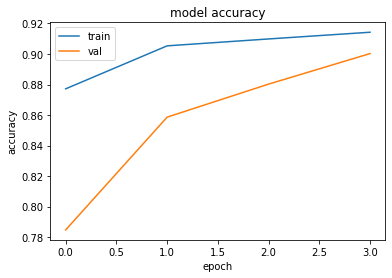

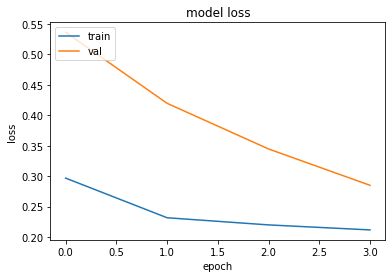

In [0]:
print_hist(history)

In [0]:
pred_valid = model.predict(val_X, batch_size=512)
best_thre = evaluate(val_y, pred_valid)




F1 score at threshold 0.1 is 0.7162299410928297
F1 score at threshold 0.11 is 0.7303626943005181
F1 score at threshold 0.12 is 0.7467628953513054
F1 score at threshold 0.13 is 0.7612231620039037
F1 score at threshold 0.14 is 0.776470588235294
F1 score at threshold 0.15 is 0.7907503967354342
F1 score at threshold 0.16 is 0.803422756706753
F1 score at threshold 0.17 is 0.8154100685417159
F1 score at threshold 0.18 is 0.8280684832408971
F1 score at threshold 0.19 is 0.8410433070866141
F1 score at threshold 0.2 is 0.8474830954169797
F1 score at threshold 0.21 is 0.8553940321346595
F1 score at threshold 0.22 is 0.8603265094584089
F1 score at threshold 0.23 is 0.8672472948007388
F1 score at threshold 0.24 is 0.8709159078735939
F1 score at threshold 0.25 is 0.8739815317762086
F1 score at threshold 0.26 is 0.8811034482758621
F1 score at threshold 0.27 is 0.8833054159687325
F1 score at threshold 0.28 is 0.8817873303167421
F1 score at threshold 0.29 is 0.8838138738224379
F1 score at threshold 0.

In [0]:
pred_test = model.predict(test_X)

In [0]:
model.predict(tokenizer.t)